In [457]:
from qiskit import QuantumCircuit, transpile, ClassicalRegister
from matplotlib import pyplot as plt
from qiskit.providers.aer import Aer
from qiskit.quantum_info import Pauli
from random import choice, choices, random
import numpy as np

In [3]:
def trotterLayer(h,J,dt,n):
    trotterLayer = QuantumCircuit(2*n)
    trotterLayer.rx(4*h*dt, range(2*n))
    trotterLayer.cx(*zip(*[(2*i, 2*i+1) for i in range(n)]))
    trotterLayer.rz(-4*J*dt, [2*i+1 for i in range(n)])
    trotterLayer.cx(*zip(*[(2*i, 2*i+1) for i in range(n)]))
    trotterLayer.cx(*zip(*[(2*i+1, 2*i+2) for i in range(n-1)]))
    trotterLayer.rz(-4*J*dt, [2*i+2 for i in range(n-1)])
    trotterLayer.cx(*zip(*[(2*i+1, 2*i+2) for i in range(n-1)]))
    return trotterLayer

h = 1
J = -.15
dt = .25
n = 2
def maketrotterCircuit(s):
    tL = trotterLayer(h, J, dt, n)
    trotterCircuit = QuantumCircuit(n*2)
    for i in range(s):
        trotterCircuit = trotterCircuit.compose(tL)
        trotterCircuit.barrier()
    return trotterCircuit

In [4]:
step = trotterLayer(h,J,dt,n)
step.draw()

┌───────┐                                            
q_0: ┤ Rx(1) ├──■────────────────■────────────────────────
     ├───────┤┌─┴─┐┌──────────┐┌─┴─┐                      
q_1: ┤ Rx(1) ├┤ X ├┤ Rz(0.15) ├┤ X ├──■────────────────■──
     ├───────┤└───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐
q_2: ┤ Rx(1) ├──■────────────────■──┤ X ├┤ Rz(0.15) ├┤ X ├
     ├───────┤┌─┴─┐┌──────────┐┌─┴─┐└───┘└──────────┘└───┘
q_3: ┤ Rx(1) ├┤ X ├┤ Rz(0.15) ├┤ X ├──────────────────────
     └───────┘└───┘└──────────┘└───┘

In [378]:
results = []
backend = Aer.get_backend('qasm_simulator')

for i in range(15):
    qc = maketrotterCircuit(i)

    measx = QuantumCircuit(n*2)
    measx.h(range(n*2))
    measy = QuantumCircuit(n*2)
    measy.sdg(range(n*2))
    measy.h(range(n*2))
    measz = QuantumCircuit(n*2)

    res = []

    for basis in [measx, measy, measz]:
        circ = qc.copy()
        circ = circ.compose(basis)
        circ.measure_all()
        result = backend.run(circ)
        count = result.result().get_counts()
        count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
        tot = 0
        for key in count.keys():
            num = sum([(-1)**bit for bit in key])
            tot += num*count[key]
        res.append(tot/(1024*n*2))
    
    results.append(tuple(res))

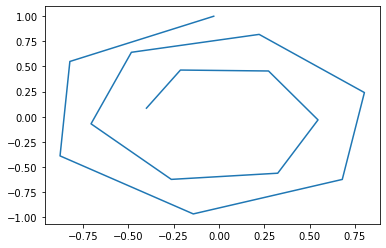

In [379]:
x,y,z = zip(*results)
plt.plot(y,z)

In [154]:
def trotterstep_to_layers(step):
    circuits = []
    new_circ = QuantumCircuit(step.num_qubits)
    old_qubits = set()
    new_qubits = set()

    for gate in step:
        if gate.operation.num_qubits == 2:
            for q in gate.qubits:
                new_qubits.add(q)

        if new_qubits.intersection(old_qubits):
            old_qubits = new_qubits.copy()
            new_qubits = set()
            circuits.append(new_circ)
            new_circ = QuantumCircuit(step.num_qubits)

        if gate.operation.num_qubits == 1 and old_qubits:
            new_qubits = set()
            old_qubits = set()
            circuits.append(new_circ)
            new_circ = QuantumCircuit(step.num_qubits)

        old_qubits = old_qubits.union(new_qubits)
        new_circ.append(gate)
        new_qubits = set()

    circuits.append(new_circ)
            
    return circuits

In [185]:
circs = trotterstep_to_layers(step)

In [202]:
qc = circs[0].copy()
qc.measure_all()
backend.run(qc).result().get_counts()

{'1011': 34,
 '1111': 26,
 '1100': 107,
 '0101': 5,
 '1001': 14,
 '1010': 34,
 '0000': 343,
 '0010': 124,
 '0011': 89,
 '0111': 13,
 '1110': 34,
 '1000': 117,
 '0110': 14,
 '1101': 8,
 '0100': 33,
 '0001': 29}

In [211]:
quack = QuantumCircuit(circs[0].qubits)
quack = quack.compose(circs[0])
quack.draw()

┌───────┐     
0: ┤ Rx(1) ├──■──
   ├───────┤┌─┴─┐
1: ┤ Rx(1) ├┤ X ├
   ├───────┤└───┘
2: ┤ Rx(1) ├──■──
   ├───────┤┌─┴─┐
3: ┤ Rx(1) ├┤ X ├
   └───────┘└───┘

Running with PEC

In [465]:
def addWithoutPhase(pauli, qc):
    p = Pauli((pauli.z, pauli.x))
    for i,p in enumerate(pauli):
        qc.append(p,[i])

class TrotterCircuit:
    def __init__(self, trotterLayers, noise_model, last_layer = None):
        #trotter layers is a list of quantum circuits decomposed as a number of single gate layers follwed by a two-qubit layer (both optional)
        #measurement_basis is the pauli expectation value to be measured
        #noise_model is a list of lists of tuples with paulis and model coefficients for sampling
        #the last_layer can be used if the trotter steps decompose in reverse order, if set it will trigger the subsequent layers to be flipped
        self.trotterLayers = trotterLayers
        self.noise_model = noise_model
        self.last_layer = last_layer
    

    def layer_with_PEC(self,layer, noise_model, last_twirl = None):
        circ = QuantumCircuit(layer.num_qubits)
        circ.data = []
        cliff = circ.copy()

        if last_twirl:
            addWithoutPhase(last_twirl, circ)

        for gate in layer:
            match gate.operation.num_qubits:
                case 1:
                    circ.append(gate)
                case 2:
                    cliff.append(gate)

        pauli = Pauli("".join(choices("IXYZ", k=layer.num_qubits))) 
        mitigation, sign = self.sample(noise_model, layer.num_qubits)

        addWithoutPhase(pauli,circ)
        addWithoutPhase(mitigation,circ)

        circ = circ.compose(cliff)

        return circ, pauli.evolve(cliff), sign

    def sample(self, noise_model,n):
        operator = Pauli("I"*n)
        sgn = 0
        for term, prob in noise_model:
            if random() < prob:
                operator = operator.compose(term)
                sgn ^= 1
        return operator, sgn

    def trotterstep_with_PEC(self, pauli = None):
        circ = QuantumCircuit(self.trotterLayers[0].num_qubits)
        overall_sign = 0
        for layer,noise_model in zip(self.trotterLayers, self.noise_model):
            qc, pauli, sgn = self.layer_with_PEC(layer, noise_model, pauli)
            circ = circ.compose(qc)
            overall_sign ^= sgn
            circ.barrier()
        return circ, overall_sign,pauli

    def trotter_with_PEC(self,reps,measurement_basis):
        circ = QuantumCircuit(self.trotterLayers[0].num_qubits)
        pauli = None
        overall_sign = 0
        for i in range(reps):
            qc,sgn,pauli = self.trotterstep_with_PEC(pauli)
            circ = circ.compose(qc)
            overall_sign ^= sgn
        if pauli:
            addWithoutPhase(pauli, circ)
        for i,m in enumerate(measurement_basis):
            match m.to_label():
                case "X":
                    qc.h(i)
                case "Y":
                    qc.sdg(i)
                    qc.h(i)
        operator, sgn = self.sample(self.noise_model[-1], 4)
        addWithoutPhase(operator, circ)
        overall_sign ^= sgn
        rostring = choices([0,1], k=4)
        addWithoutPhase(Pauli(([0]*4, rostring)), circ) 
        
        return circ, overall_sign, rostring[::-1]

In [466]:
l = [(Pauli("XXII"), -1), (Pauli("IIXX"), -1)]
tl = TrotterCircuit(circs, [l]*4)

In [467]:
circ,pauli,sign = tl.layer_with_PEC(circs[0], l)
circ.draw()

┌───────┐┌───┐┌───┐     
q_0: ┤ Rx(1) ├┤ X ├┤ I ├──■──
     ├───────┤├───┤├───┤┌─┴─┐
q_1: ┤ Rx(1) ├┤ X ├┤ I ├┤ X ├
     ├───────┤├───┤├───┤└───┘
q_2: ┤ Rx(1) ├┤ Y ├┤ I ├──■──
     ├───────┤├───┤├───┤┌─┴─┐
q_3: ┤ Rx(1) ├┤ I ├┤ I ├┤ X ├
     └───────┘└───┘└───┘└───┘

In [468]:
results = []
backend = Aer.get_backend('qasm_simulator')



In [469]:
results2 = []
backend = Aer.get_backend('qasm_simulator')

for i in range(15):
    qc,_,rostring = tl.trotter_with_PEC(i,Pauli("ZZ"))

    measx = QuantumCircuit(n*2)
    measx.h(range(n*2))
    measy = QuantumCircuit(n*2)
    measy.sdg(range(n*2))
    measy.h(range(n*2))
    measz = QuantumCircuit(n*2)

    res = []

    for basis in [measx, measy, measz]:
        circ = qc.copy()
        circ = circ.compose(basis)
        circ.measure_all()
        result = backend.run(circ)
        count = result.result().get_counts()
        count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
        tot = 0
        for key in count.keys():
            num = sum([(-1)**bit for bit in np.bitwise_xor(key, rostring)])
            tot += num*count[key]
        res.append(tot/(1024*n*2))
    
    results2.append(tuple(res))

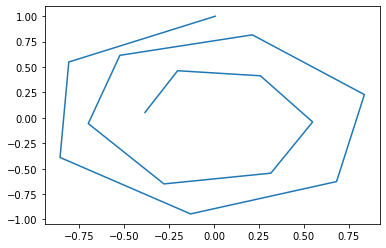

In [470]:
x,y,z = zip(*results2)
plt.plot(y,z)